In [1]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier

LOCAL = '../data/tanzania/'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'
source = WEB

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
                 pd.read_csv(source + 'train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(source + 'test_features.csv')
sample_submission = pd.read_csv(source + 'sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)


def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    X = X.drop(columns=['recorded_by', 'id'])
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [2]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [3]:
train.head()

amount_tsh                  funder  gps_height installer  longitude  \
43360         0.0                     NaN         NaN       NaN  33.542898   
7263        500.0               Rc Church      2049.0      ACRA  34.665760   
2486         25.0                   Donor       290.0        Do  38.238568   
313           0.0  Government Of Tanzania         NaN       DWE  30.716727   
52726         0.0                   Water         NaN      Gove  35.389331   

       latitude             wpt_name  num_private          basin   subvillage  \
43360 -9.174777         Kwa Mzee Noa            0     Lake Nyasa  Mpandapanda   
7263  -9.308548  Kwa Yasinta Ng'Ande            0         Rufiji      Kitichi   
2486  -6.179919          Kwasungwini            0    Wami / Ruvu   Kwedigongo   
313   -1.289055           Kwajovin 2            0  Lake Victoria      Kihanga   
52726 -6.399942                Chama            0       Internal       Mtakuj   

       ...         source   source_type  source_class     waterpoint_type  \
43360  ...         spring        spring   groundwater  communal standpipe   
7263   ...         spring        spring   groundwater  communal standpipe   
2486   ...   shallow well  shallow well   groundwater           hand pump   
313    ...   shallow well  shallow well   groundwater               other   
52726  ...    machine dbh      borehole   groundwater  communal standpipe   

      waterpoint_type_group    status_group year_recorded month_recorded  \
43360    communal standpipe      functional          2011              7   
7263     communal standpipe      functional          2011              3   
2486              hand pump      functional          2011              3   
313                   other  non functional          2011              7   
52726    communal standpipe      functional          2011              3   

      day_recorded years  
43360           27  2011  
7263            23     3  
2486             7     1  
313             31  2011  
52726           10  2011  

[5 rows x 41 columns]

In [4]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

# Make pipeline!
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    DecisionTreeClassifier(max_depth=20, random_state=42)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-03.csv', index=False)

Validation Accuracy 0.7712121212121212


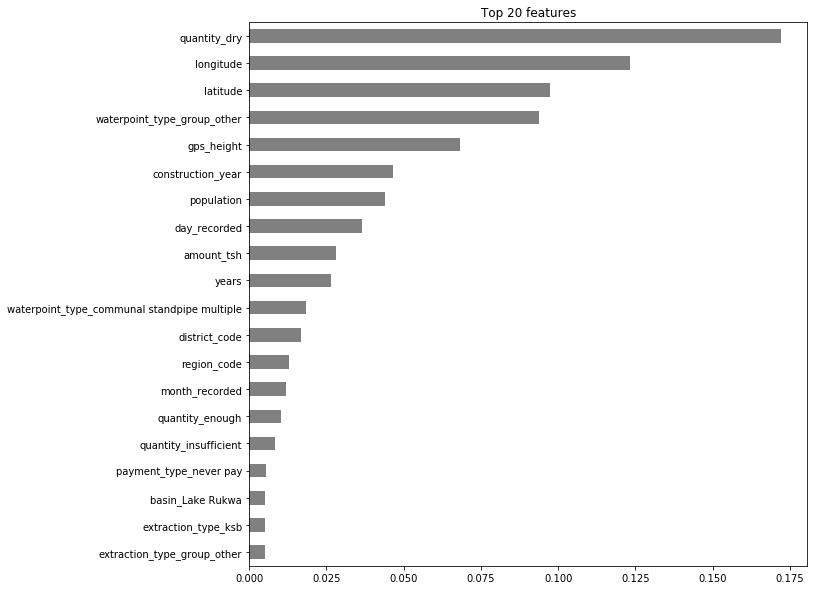

In [5]:
# Get feature importances
encoder = pipeline.named_steps['onehotencoder']
tree = pipeline.named_steps['decisiontreeclassifier']

feature_names = encoder.transform(X_val).columns

importances = pd.Series(tree.feature_importances_, feature_names)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [6]:
y_train.value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

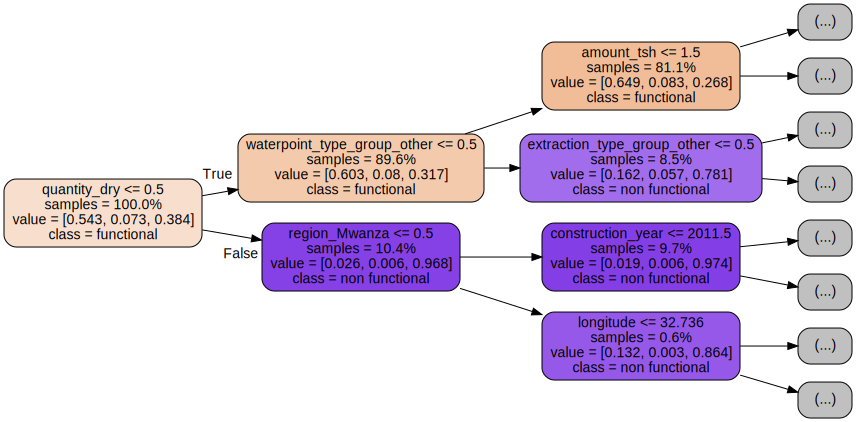

In [7]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, 
                           out_file=None, 
                           max_depth=2, 
                           feature_names=feature_names, 
                           class_names=tree.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rotate=True, 
                           rounded=True)

graphviz.Source(dot_data)

In [8]:
# TODO

from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-04.csv', index=False)

Validation Accuracy 0.8087542087542088


In [9]:
encoder = pipeline.named_steps['onehotencoder']
encoded_shape = encoder.transform(X_train).shape
print(encoded_shape, X_train.shape)

(47520, 183) (47520, 33)


In [10]:
# TODO

X_train = train.drop(columns=target)
y_train = train[target]

X_val = val.drop(columns=target)
y_val = val[target]

X_test = test

In [11]:
X_train.shape

(47520, 40)

In [18]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=300,
                           min_samples_split=3,
                           random_state=42, 
                           n_jobs=-1)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-rf-ordinal.csv', index=False)

Train Accuracy 0.9974747474747475
Validation Accuracy 0.8164141414141414


In [14]:
encoder = pipeline.named_steps['ordinalencoder']
X_train_encoded = encoder.transform(X_train)
print(X_train_encoded.shape, X_train.shape)

(47520, 40) (47520, 40)


In [15]:
X_train.head()

amount_tsh                  funder  gps_height installer  longitude  \
43360         0.0                     NaN         NaN       NaN  33.542898   
7263        500.0               Rc Church      2049.0      ACRA  34.665760   
2486         25.0                   Donor       290.0        Do  38.238568   
313           0.0  Government Of Tanzania         NaN       DWE  30.716727   
52726         0.0                   Water         NaN      Gove  35.389331   

       latitude             wpt_name  num_private          basin   subvillage  \
43360 -9.174777         Kwa Mzee Noa            0     Lake Nyasa  Mpandapanda   
7263  -9.308548  Kwa Yasinta Ng'Ande            0         Rufiji      Kitichi   
2486  -6.179919          Kwasungwini            0    Wami / Ruvu   Kwedigongo   
313   -1.289055           Kwajovin 2            0  Lake Victoria      Kihanga   
52726 -6.399942                Chama            0       Internal       Mtakuj   

       ...       quantity        source   source_type source_class  \
43360  ...   insufficient        spring        spring  groundwater   
7263   ...         enough        spring        spring  groundwater   
2486   ...   insufficient  shallow well  shallow well  groundwater   
313    ...         enough  shallow well  shallow well  groundwater   
52726  ...         enough   machine dbh      borehole  groundwater   

          waterpoint_type  waterpoint_type_group year_recorded month_recorded  \
43360  communal standpipe     communal standpipe          2011              7   
7263   communal standpipe     communal standpipe          2011              3   
2486            hand pump              hand pump          2011              3   
313                 other                  other          2011              7   
52726  communal standpipe     communal standpipe          2011              3   

      day_recorded years  
43360           27  2011  
7263            23     3  
2486             7     1  
313             31  2011  
52726           10  2011  

[5 rows x 40 columns]

In [16]:
X_train_encoded.head()

amount_tsh  funder  gps_height  installer  longitude  latitude  \
43360         0.0       1         NaN          1  33.542898 -9.174777   
7263        500.0       2      2049.0          2  34.665760 -9.308548   
2486         25.0       3       290.0          3  38.238568 -6.179919   
313           0.0       4         NaN          4  30.716727 -1.289055   
52726         0.0       5         NaN          5  35.389331 -6.399942   

       wpt_name  num_private  basin  subvillage  ...    quantity  source  \
43360         1            0      1           1  ...           1       1   
7263          2            0      2           2  ...           2       1   
2486          3            0      3           3  ...           1       2   
313           4            0      4           4  ...           2       2   
52726         5            0      5           5  ...           2       3   

       source_type  source_class  waterpoint_type  waterpoint_type_group  \
43360            1             1                1                      1   
7263             1             1                1                      1   
2486             2             1                2                      2   
313              2             1                3                      3   
52726            3             1                1                      1   

       year_recorded  month_recorded  day_recorded  years  
43360           2011               7            27   2011  
7263            2011               3            23      3  
2486            2011               3             7      1  
313             2011               7            31   2011  
52726           2011               3            10   2011  

[5 rows x 40 columns]